In [1]:
%cd ..
%cd ..

C:\GitHub\LayoutDiffusion\layout_diffusion
C:\GitHub\LayoutDiffusion


In [2]:
import os
import random
from collections import defaultdict
import torch
import torchvision.transforms as T
import numpy as np
import h5py
import PIL
import pickle
from layout_diffusion.dataset.util import image_normalize
from layout_diffusion.dataset.augmentations import RandomSampleCrop, RandomMirror
from torch.utils.data import Dataset
import json
from PIL import Image

C:\Users\susha\anaconda3\envs\meronymnet\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\susha\anaconda3\envs\meronymnet\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\susha\anaconda3\envs\meronymnet\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from omegaconf import OmegaConf
from layout_diffusion.dataset.data_loader import build_loaders
import matplotlib.pyplot as plt

In [4]:

def labels_from_class_and_part(X_train_vector,class_v_vector):
    # Broadcasting to match dimensions
    X_train_expanded = np.expand_dims(X_train_vector, axis=0)
    class_v_expanded = np.expand_dims(class_v_vector, axis=1)
    # Perform the dor product
    return np.dot(class_v_expanded,X_train_expanded)


In [5]:
def filtered_labels(labels_v,class_comb_dict):
    label = []
    for i, x in enumerate(class_comb_dict.values()):
        #print(x)
        label = label + list(labels_v[i,:len(x.keys())])
        #print(len(x.keys()))
        
    #print(len(label),label)
    return np.array(label)


In [6]:
def get_class_and_part_names(index_class_dict,class_comb_dict,index_part_list,X, class_v):
    x = np.where(class_v == 1)
    class_name = index_class_dict[int(x[0])]
    #print(class_name)
    labels_v = labels_from_class_and_part(X[ :, 0], class_v)
    #print(labels_v)            
    final_labels = filtered_labels(labels_v,class_comb_dict)
    labels_v = labels_v.flatten()#[0:16]
    #print(len(class_comb_dict[class_name].keys()))
    
    y = np.where(X[:, 0] == 1)
    
    all_part_names = []
    for i, t in enumerate(class_comb_dict[class_name]):
        #print(i,t)
        part_names = []
        if i in list(y[0]):
            for parts in class_comb_dict[class_name][t]:
                #print(parts)
                part_names.append(index_part_list[int(x[0])][parts])
                #print(index_part_list[int(x[0])][parts])
            #print("\n")
        if len(part_names)>0:
            all_part_names.append(part_names)
    return class_name, all_part_names , final_labels

In [7]:
class MeronymnetDataset(Dataset):
    
    
    def __init__(self, images , X, class_v, index_class_dict, index_part_list, class_comb_dict, image_size=(256, 256),
                 max_objects_per_image=16, max_num_samples=None, mask_size=32,
                 use_orphaned_objects=True,  
                 left_right_flip=False, min_object_size=1/256, use_MinIoURandomCrop=False,
                 return_origin_image=False, specific_image_ids=[]
                 ):
        super(MeronymnetDataset, self).__init__()

        self.return_origin_image = return_origin_image
        if self.return_origin_image:
            self.origin_transform = T.Compose([
                T.ToTensor(),
                image_normalize()
            ])

        self.images = images
        self.X = X
        self.class_v = class_v
        self.index_class_dict = index_class_dict
        self.index_part_list = index_part_list
        self.class_comb_dict = class_comb_dict
        self.mask_size = mask_size
        self.image_size = image_size
        self.min_object_size = min_object_size
        # self.vocab = vocab
        self.num_objects = 94
        self.use_orphaned_objects = use_orphaned_objects
        self.max_objects_per_image = max_objects_per_image
        self.max_num_samples = max_num_samples
        self.left_right_flip = left_right_flip
        if left_right_flip:
            self.random_flip = RandomMirror()

        self.use_MinIoURandomCrop = use_MinIoURandomCrop
        if use_MinIoURandomCrop:
            self.MinIoURandomCrop = RandomSampleCrop()

        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize(size=image_size, antialias=True),
            image_normalize()
        ])

        self.total_num_bbox = 0
        self.total_num_invalid_bbox = 0
        
                     
        '''
        with h5py.File(h5_path, 'r') as f:
            for k, v in f.items():
                if k == 'image_paths':
                    # self.image_
                    self.image_paths = [str(path, encoding="utf-8") for path in list(v)]
                else:
                    self.data[k] = torch.IntTensor(np.asarray(v))
        
        '''
        
        self.data = {}
        self.data['images'] = []
        self.data['objects_per_image'] = []
        self.data['object_boxes'] =[]
        self.data['object_names'] =  []
        self.data['object_class']=[]
                     
        for i in range(len(images)):
            #print(i)
            boxes = []
            self.data['images'].append(images[i])
            for j in range(len(X[i])):
                if(self.X[i,j,0]==1):
                    boxes.append(X[i,j,1:])
            self.data['object_boxes'].append(np.asarray(boxes))
            class_name,all_part_names,labels_v = get_class_and_part_names(self.index_class_dict,self.class_comb_dict ,self.index_part_list ,self.X[i,:,:],class_v[i])
            object_names = []
            for i in range(len(all_part_names)):
                object_names.append(class_name+' '+' '.join(all_part_names[i]))
            self.data['object_names'].append(object_names)
            self.data['objects_per_image'].append(len(object_names))
            self.data['object_class'].append(np.where(labels_v==1)[0]+1) # 1 to 112 
            
            #self.data['relationship_subjects'] = 

        '''
        self.vocab = {
            'object_name_to_idx': {},
            'pred_name_to_idx': {},
        }
        object_idx_to_name = {}
        all_instance_categories = []
        for category_data in instances_data['categories']:
            category_id = category_data['id']
            category_name = category_data['name']
            all_instance_categories.append(category_name)
            object_idx_to_name[category_id] = category_name
            self.vocab['object_name_to_idx'][category_name] = category_id
        all_stuff_categories = []
        if stuff_data:
            for category_data in stuff_data['categories']:
                category_name = category_data['name']
                category_id = category_data['id']
                all_stuff_categories.append(category_name)
                object_idx_to_name[category_id] = category_name
                self.vocab['object_name_to_idx'][category_name] = category_id

        '''            
        # get specific image ids or get specific number of images
        selected_idx = []
        self.specific_image_ids = specific_image_ids
        if self.specific_image_ids:
            specific_image_ids_set = set(specific_image_ids)
            for idx, image_path in enumerate(self.image_paths):
                if image_path in specific_image_ids_set:
                    selected_idx.append(idx)
                    specific_image_ids_set.remove(image_path)
                if len(specific_image_ids_set) == 0:
                    break

            if len(specific_image_ids_set) > 0:
                for image_path in list(specific_image_ids_set):
                    print('image path: {} is not found'.format(image_path))

            assert len(specific_image_ids_set) == 0
        elif self.max_num_samples:
            selected_idx = [idx for idx in range(self.max_num_samples)]

        if selected_idx:
            print('selected_idx = {}'.format(selected_idx))
            self.image_paths = [self.image_paths[idx] for idx in selected_idx]
            for k in list(self.data.keys()):
                self.data[k] = self.data[k][selected_idx]

    def check_with_relation(self, image_index):
        '''
        :param obj_idxs: the idxs of objects of image
        :return: with_relations = [True, False, ....], shape=(O,), O is the number of objects
        '''
        obj_idxs = range(self.data['objects_per_image'][image_index].item())
        with_relations = [False for i in obj_idxs]
        for r_idx in range(self.data['relationships_per_image'][image_index]):
            s = self.data['relationship_subjects'][image_index, r_idx].item()
            o = self.data['relationship_objects'][image_index, r_idx].item()
            with_relations[s] = True
            with_relations[o] = True
        without_relations = [not i for i in with_relations]
        return with_relations, without_relations

    def filter_invalid_bbox(self, H, W, bbox, is_valid_bbox, verbose=False):

        for idx, obj_bbox in enumerate(bbox):
            if not is_valid_bbox[idx]:
                continue
            
            self.total_num_bbox += 1
            x, y, w, h = obj_bbox
            #print(obj_bbox)
            if (x >= W) or (y >= H):
                is_valid_bbox[idx] = False
                print(self.total_num_invalid_bbox)
                self.total_num_invalid_bbox += 1
                if verbose:
                    print(
                        'total_num = {}, invalid_num = {}, x = {}, y={}, w={}, h={}, W={}, H={}'.format(
                            self.total_num_bbox, self.total_num_invalid_bbox, x, y, w, h, W, H,
                        )
                    )
                continue

            x0, y0, x1, y1 = x, y, x + w, y + h
            x1 = np.clip(x + w, 0, W)
            y1 = np.clip(y + h, 0, H)
            #print(x0,y0,x1,y1)
            if (y1 - y0 < self.min_object_size) or (x1 - x0 < self.min_object_size):
                print(y1-y0,x1-x0)
                print("invalid-",idx)
                is_valid_bbox[idx] = False
                self.total_num_invalid_bbox += 1
                if verbose:
                    print(
                        'total_num = {}, invalid_num = {}, x = {}, y={}, w={}, h={}, W={}, H={}'.format(
                            self.total_num_bbox, self.total_num_invalid_bbox, x, y, w, h, W, H,
                        )
                    )
                continue
            bbox[idx][0], bbox[idx][1], bbox[idx][2], bbox[idx][3] = x0, y0, x1, y1

        return bbox, is_valid_bbox

    def get_init_meta_data(self, image_index):
        layout_length = self.max_objects_per_image + 2
        meta_data = {
            'obj_bbox': torch.zeros([layout_length, 4]),
            'obj_class': torch.LongTensor(layout_length).fill_(self.num_objects + 1),
            'obj_class_name':['_null_']*layout_length,
            'is_valid_obj': torch.zeros([layout_length]),
        }

        # The first object will be the special __image__ object
        meta_data['obj_bbox'][0] = torch.FloatTensor([0, 0, 1, 1])
        meta_data['obj_class'][0] = 0
        meta_data['is_valid_obj'][0] = 1.0
        meta_data['obj_class_name'][0]= '__image__'

        return meta_data

    def __len__(self):
        num = len(self.data['object_names'])
        assert num == len(self.data['object_class'])
        return num

    def __getitem__(self, index):
        """
        Returns a tuple of:
        - image: FloatTensor of shape (C, H, W)
        - objs: LongTensor of shape (O,)
        - boxes: FloatTensor of shape (O, 4) giving boxes for objects in
          (x0, y0, x1, y1) format, in a [0, 1] coordinate system.
        """

        # Figure out which objects appear in relationships and which don't
        # with_relations, without_relations = self.check_with_relation(image_index=index)  # (O,)

        image = self.data['images'][index]
        if self.return_origin_image:
            origin_image = np.array(image, dtype=np.float32) / 255.0
        
        image = np.array(image, dtype=np.float32) / 255.0
        H, W, _ = 1,1,1
        num_obj = self.data['objects_per_image'][index]
        obj_bbox = self.data['object_boxes'][index][:num_obj]
        #print(obj_bbox)
        obj_class = self.data['object_class'][index][:num_obj]
        obj_class_name = self.data['object_names'][index][:num_obj]
        is_valid_obj = (obj_class >= 0)
        #print(obj_bbox)
        #get meta data
        meta_data = self.get_init_meta_data(image_index=index)
        meta_data['width'], meta_data['height'] = W, H
        #meta_data['with_relations'] = with_relations

        # filter invalid bbox
        
        obj_bbox, is_valid_obj = self.filter_invalid_bbox(H=H, W=W, bbox=obj_bbox, is_valid_bbox=is_valid_obj)
        #print(obj_bbox)
        #print(is_valid_obj)
        
        # flip
        if self.left_right_flip:
            #plt.imshow(image)
            #plt.show()
            image, obj_bbox, obj_class = self.random_flip(image, obj_bbox, obj_class)

        # random crop image and its bbox
        if self.use_MinIoURandomCrop:
            #plt.imshow(image)
            #plt.show()
            image, updated_obj_bbox, updated_obj_class, tmp_is_valid_obj = self.MinIoURandomCrop(image, obj_bbox[is_valid_obj], obj_class[is_valid_obj])

            tmp_idx = 0
            tmp_tmp_idx = 0
            for idx, is_valid in enumerate(is_valid_obj):
                if is_valid:
                    if tmp_is_valid_obj[tmp_idx]:
                        obj_bbox[idx] = updated_obj_bbox[tmp_tmp_idx]
                        tmp_tmp_idx += 1
                    else:
                        is_valid_obj[idx] = False
                    tmp_idx += 1

            meta_data['new_height'] = image.shape[0]
            meta_data['new_width'] = image.shape[1]
            H, W, _ = image.shape
        
        #print(obj_bbox,is_valid_obj)
        obj_bbox = torch.FloatTensor(obj_bbox[is_valid_obj])
        obj_class = torch.LongTensor(obj_class[is_valid_obj])

        #obj_bbox[:, 0::2] = obj_bbox[:, 0::2] 
        #obj_bbox[:, 1::2] = obj_bbox[:, 1::2] 
        #print(obj_bbox)

        num_selected = min(obj_bbox.shape[0], self.max_objects_per_image)
        #print(num_selected)
        selected_obj_idxs = range(0, num_selected)
        meta_data['obj_bbox'][1:1 + num_selected] = obj_bbox[selected_obj_idxs]
        meta_data['obj_class'][1:1 + num_selected] = obj_class[selected_obj_idxs]
        meta_data['is_valid_obj'][1:1 + num_selected] = 1.0
        meta_data['num_selected'] = num_selected
        meta_data['num_add'] = 0
        meta_data['obj_class_name'][1:1+num_selected] = obj_class_name
        meta_data['num_obj'] = meta_data['num_selected'] + meta_data['num_add'] - 1
        #plt.imshow(np.asarray(self.transform(image)).transpose(1,2,0))
        #plt.show()
        #print(np.asarray(self.transform(image)).transpose(1,2,0).max())
        if self.return_origin_image:
            meta_data['origin_image'] = self.origin_transform(origin_image)
        
        return self.transform(image), meta_data

'''
        if num_selected < self.max_objects_per_image and self.use_orphaned_objects:
            num_add = min(self.max_objects_per_image - num_selected, obj_bbox_without_relations.shape[0])
            if num_add > 0:
                selected_obj_idxs = random.sample(range(obj_bbox_without_relations.shape[0]), num_add)
                meta_data['obj_bbox'][1 + num_selected:1 + num_selected + num_add] = obj_bbox_without_relations[selected_obj_idxs]
                meta_data['obj_class'][1 + num_selected:1 + num_selected + num_add] = obj_class_without_relations[selected_obj_idxs]
                meta_data['is_valid_obj'][1 + num_selected:1 + num_selected + num_add] = 1.0
                meta_data['num_add'] = num_add
'''
def mn_collate_fn_for_layout(batch):
    """
    Collate function to be used when wrapping CocoSceneGraphDataset in a
    DataLoader. Returns a tuple of the following:

    - imgs: FloatTensor of shape (N, C, H, W)
    - objs: LongTensor of shape (N, L) giving object categories
    - masks: FloatTensor of shape (N, L, H, W)
    - is_valid_obj: FloatTensor of shape (N, L)
    """

    all_meta_data = defaultdict(list)
    all_imgs = []

    for i, (img, meta_data) in enumerate(batch):
        all_imgs.append(img[None])
        for key, value in meta_data.items():
            all_meta_data[key].append(value)

    all_imgs = torch.cat(all_imgs)
    for key, value in all_meta_data.items():
        if key in ['obj_bbox', 'obj_class', 'is_valid_obj'] or key.startswith('labels_from_layout_to_image_at_resolution'):
            all_meta_data[key] = torch.stack(value)

    return all_imgs, all_meta_data




def load_data(mode):
    data_path = 'C:/GitHub/meronymnet/data_np_16/'
    part_data_post_fix = '_scaled_sqr'
    obj_data_postfix = '_obj_boundary_sqr'
    file_postfix = '_combined_mask_data'

    if mode == 'train':
        X_file = 'X_train' + part_data_post_fix + '.np'
        class_v_file = 'class_v' + file_postfix + '.np'
        images_file = 'images_train' + file_postfix + '.np'
    elif mode == 'val':
        X_file = 'X_train_val' + part_data_post_fix + '.np'
        class_v_file = 'class_v_val' + file_postfix + '.np'
        images_file = 'images_val' + file_postfix + '.np'
    elif mode == 'test':
        X_file = 'X_test' + part_data_post_fix + '.np'
        class_v_file = 'class_v_test' + file_postfix + '.np'
        images_file = 'images_test' + file_postfix + '.np'
    else:
        raise ValueError("Invalid mode. Mode should be 'train', 'val', or 'test'.")

    with open(data_path + X_file, 'rb') as pickle_file:
        X = pickle.load(pickle_file)

    with open(data_path + class_v_file, 'rb') as pickle_file:
        class_v = pickle.load(pickle_file)

    with open(data_path + images_file, 'rb') as pickle_file:
        images = pickle.load(pickle_file)

    return X, class_v, images


def build_mn_dsets(cfg, mode='train'):
    assert mode in ['train', 'val', 'test']
    X,class_v,images = load_data(mode)
    #print(X[0])
    X[:, :, 4] = X[:, :, 4] - X[:, :, 2]
    X[:, :, 3] = X[:, :, 3] - X[:, :, 1]

    params = cfg.data.parameters
    
    '''with open(os.path.join(params.root_dir, params.vocab_json), 'r') as f:
        vocab = json.load(f)
    '''
    #object_names = ['bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'person']

    #part labels
    bird_labels = {'head':1, 'leye':2, 'reye':3, 'beak':4, 'torso':5, 'neck':6, 'lwing':7, 'rwing':8, 'lleg':9, 'lfoot':10, 'rleg':11, 'rfoot':12, 'tail':13}

    cat_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17}

    cow_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lhorn':7, 'rhorn':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19}

    dog_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17, 'muzzle':18}

    horse_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lfho':7, 'rfho':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19, 'lbho':20, 'rbho':21}
    
    sheep_labels = cow_labels

    person_labels = {'head':1, 'leye':2,  'reye':3, 'lear':4, 'rear':5, 'lebrow':6, 'rebrow':7,  'nose':8,  'mouth':9,  'hair':10, 'torso':11, 'neck': 12, 'llarm': 13, 'luarm': 14, 'lhand': 15, 'rlarm':16, 'ruarm':17, 'rhand': 18, 'llleg': 19, 'luleg':20, 'lfoot':21, 'rlleg':22, 'ruleg':23, 'rfoot':24}
    
    
    bird_comb = {
        1 : [1, 2, 3, 4],
        5 : [5],
        6 : [6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13]
    }

    cat_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17]
    }
    cow_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19]
    }
    dog_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18]
    }
    horse_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19],
        20 : [20],
        21 : [21]
    }
    sheep_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19]
    }
    person_comb = {
        1 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19],
        20 : [20],
        21 : [21],
        22 : [22],
        23 : [23],
        24 : [24],
    }
    #Should be in same order
    part_dict = {
        'cow' : cow_labels,
        'sheep' : sheep_labels,
        'bird' : bird_labels,
        'person' : person_labels,
        'cat' : cat_labels,
        'dog' : dog_labels,
        'horse' : horse_labels

    }

    class_comb_dict = {
        'cow' : cow_comb,
        'sheep' : sheep_comb,
        'bird' : bird_comb,
        'person' : person_comb,
        'cat' : cat_comb,
        'dog' : dog_comb,
        'horse' : horse_comb 
    }

    #labels_v = []
    class_dict = {'cow':0,'sheep':1,'bird':2,'person':3,'cat':4,'dog':5,'horse':6,'aeroplane':7,'motorbike':8,'bicycle':9,'car':10}
    index_class_dict = {index: name for index, name in enumerate(class_dict)}
    print(index_class_dict)
    
    index_part_dict = {index: name for index, name in enumerate(class_dict)}
    
    part_dict_list  = [ part_dict[name] for index, name in enumerate(part_dict)]
    
    index_part_list = []
    for i,part_dict in enumerate(part_dict_list):
        index_part_list.append({index+1: name for index, name in enumerate(part_dict)})
            
    #print(vocab)
    #vocab['object_name_to_idx']['__image__'] = 0
    #vocab['object_name_to_idx']['__null__'] = 179
    #vocab['object_idx_to_name'].append('__null__')

    dataset = MeronymnetDataset(
        images = images,
        X = X,
        class_v = class_v,
        index_class_dict=index_class_dict,
        index_part_list=index_part_list,
        class_comb_dict=class_comb_dict,
        image_size=(params.image_size, params.image_size),
        mask_size=params.mask_size_for_layout_object,
        max_num_samples=params[mode].max_num_samples,
        max_objects_per_image=params.max_objects_per_image,
        left_right_flip=params[mode].left_right_flip,
        use_orphaned_objects=params.use_orphaned_objects,
        use_MinIoURandomCrop=params[mode].use_MinIoURandomCrop,
        return_origin_image=params.return_origin_image,
        specific_image_ids=params[mode].specific_image_ids
    )

    num_imgs = len(dataset)
    print('%s dataset has %d images' % (mode, num_imgs))

    return dataset

In [8]:
cfg = OmegaConf.load('./configs/MN_256x256/LayoutDiffusion_large.yaml')
#print(cfg)
train_loader = build_mn_dsets(cfg, mode='train')

{0: 'cow', 1: 'sheep', 2: 'bird', 3: 'person', 4: 'cat', 5: 'dog', 6: 'horse', 7: 'aeroplane', 8: 'motorbike', 9: 'bicycle', 10: 'car'}
train dataset has 3394 images


In [9]:
def plot_bbx(bbx):
    bbx = bbx*canvas_size
    canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
    for i, coord in enumerate(bbx):
        x_minp, y_minp,x_maxp , y_maxp = coord[:4]
        if [x_minp, y_minp, x_maxp, y_maxp]!=[0,0,0,0]:
            cv2.rectangle(canvas, (int(x_minp), int(y_minp)), (int(x_maxp) , int(y_maxp) ), colors[i], 6)
    return canvas

In [10]:
import cv2

In [11]:
colors = [(1, 0, 0),
          (0.737, 0.561, 0.561),
          (0.255, 0.412, 0.882),
          (0.545, 0.271, 0.0745),
          (0.98, 0.502, 0.447),
          (0.98, 0.643, 0.376),
          (0.18, 0.545, 0.341),
          (0.502, 0, 0.502),
          (0.627, 0.322, 0.176),
          (0.753, 0.753, 0.753),
          (0.529, 0.808, 0.922),
          (0.416, 0.353, 0.804),
          (0.439, 0.502, 0.565),
          (0.784, 0.302, 0.565),
          (0.867, 0.627, 0.867),
          (0, 1, 0.498),
          (0.275, 0.51, 0.706),
          (0.824, 0.706, 0.549),
          (0, 0.502, 0.502),
          (0.847, 0.749, 0.847),
          (1, 0.388, 0.278),
          (0.251, 0.878, 0.816),
          (0.933, 0.51, 0.933),
          (0.961, 0.871, 0.702)]
colors = (np.asarray(colors)*255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.6875, 0.1250, 1.0000, 0.2375],
        [0.1500, 0.1750, 0.7625, 0.6750],
        [0.6000, 0.1625, 0.7625, 0.4875],
        [0.0625, 0.6875, 0.3000, 0.8625],
        [0.4000, 0.6500, 0.4625, 0.8375],
        [0.0000, 0.5375, 0.1625, 0.6750],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 34, 36, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lleg', 'bird rleg', 'bird tail', '_null_'

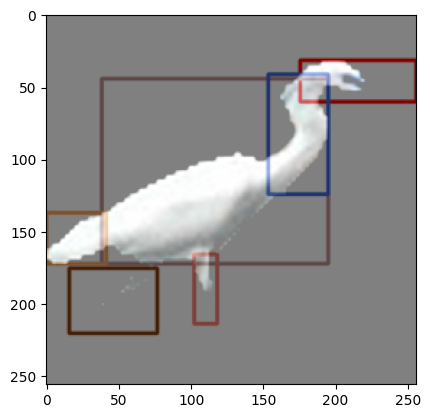

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.8082, 0.0274, 1.0000, 0.1781],
        [0.2329, 0.1507, 1.0000, 0.7123],
        [0.7945, 0.1644, 0.9863, 0.2603],
        [0.7123, 0.6986, 0.7260, 0.8904],
        [0.6301, 0.7260, 0.7397, 0.9726],
        [0.6301, 0.9178, 0.7397, 0.9726],
        [0.0000, 0.5479, 0.2329, 0.6027],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 34, 36, 37, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lleg', 'bird rleg', 'bird rfoot', 'bird t

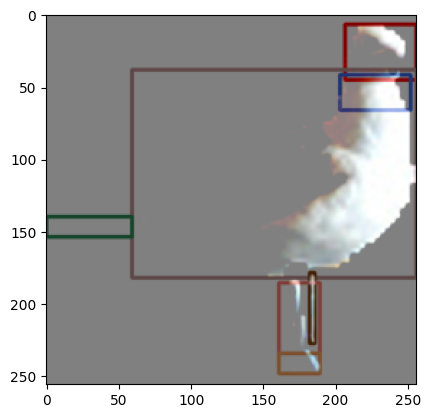

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.5627, 0.0000, 0.7204, 0.1613],
        [0.4014, 0.1111, 0.6989, 0.4910],
        [0.3692, 0.3333, 0.6093, 0.6129],
        [0.2832, 0.5197, 0.5125, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 33, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird rwing', 'bird tail', '_null_', '_null_', '_null_', '_n

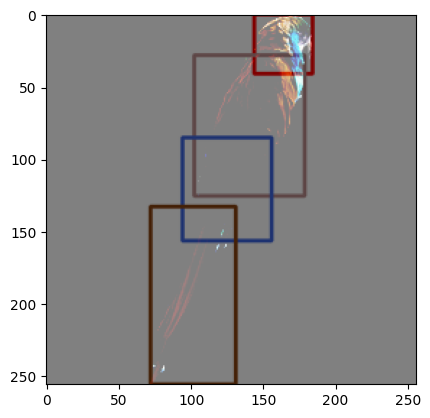

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.1941, 0.5765, 0.4471],
        [0.3882, 0.3824, 0.9294, 0.7471],
        [0.3412, 0.3294, 0.5706, 0.4529],
        [0.4882, 0.6588, 0.5647, 0.7824],
        [0.4647, 0.7647, 0.5235, 0.7882],
        [0.7588, 0.6941, 1.0000, 0.8059],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 34, 35, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lleg', 'bird lfoot', 'bird tail', '_null_

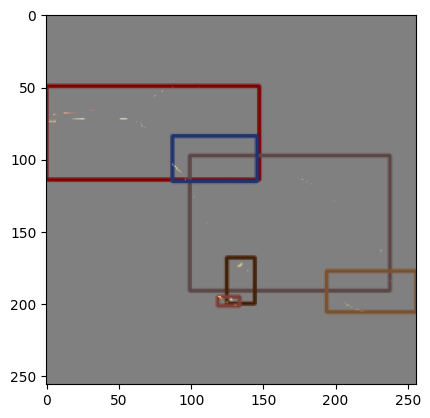

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.4762, 0.4206, 0.5873, 0.4841],
        [0.3810, 0.4762, 0.5238, 0.7222],
        [0.4683, 0.4841, 0.5238, 0.5079],
        [0.5159, 0.5397, 1.0000, 0.6508],
        [0.0000, 0.2381, 0.4365, 0.6111],
        [0.4048, 0.7302, 0.4127, 0.7619],
        [0.3810, 0.7302, 0.3889, 0.7619],
        [0.3571, 0.6984, 0.4524, 0.7619],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 32, 33, 34, 36, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lwing', 'bird rwing', 'bird lleg', 'bird 

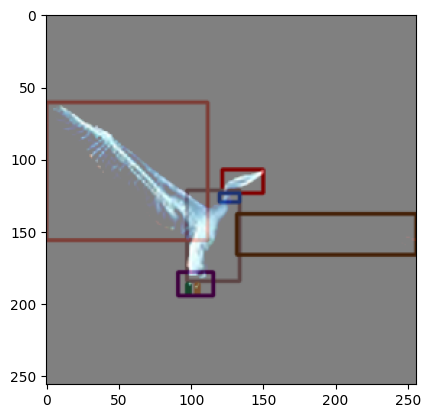

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.2751, 0.2011],
        [0.0159, 0.1005, 0.8624, 0.6561],
        [0.4074, 0.5926, 0.5450, 1.0000],
        [0.4021, 0.8889, 0.4603, 1.0000],
        [0.1852, 0.5291, 0.2804, 0.6720],
        [0.6402, 0.5767, 1.0000, 0.9683],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 34, 35, 36, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird lleg', 'bird lfoot', 'bird rleg', 'bird tail', '_null_

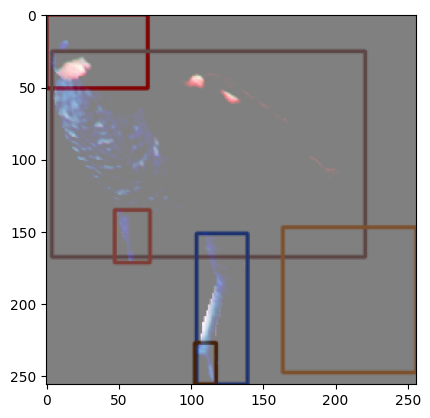

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0433, 0.0000, 0.9543, 0.7428],
        [0.0433, 0.5553, 0.9207, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', '_null_', '_null_', '_null_', '_null_', '_null_', '_null_', 

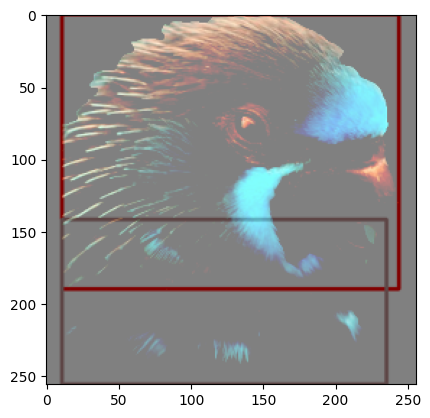

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.4568, 0.0000, 0.7160, 0.1605],
        [0.2469, 0.1358, 0.7531, 0.8765],
        [0.4321, 0.1358, 0.6420, 0.2963],
        [0.5679, 0.7901, 0.6173, 1.0000],
        [0.3951, 0.8148, 0.4198, 0.9877],
        [0.3580, 0.8519, 0.6543, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 34, 36, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lleg', 'bird rleg', 'bird tail', '_null_'

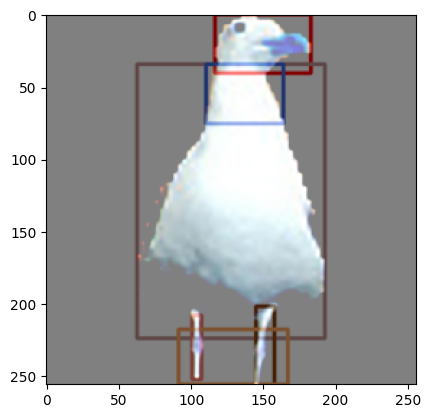

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0379, 0.0000, 0.4461, 0.4956],
        [0.3878, 0.0554, 0.9650, 1.0000],
        [0.4198, 0.0583, 0.8280, 0.5860],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', '_null_', '_null_', '_null_', '_null_', '_null_

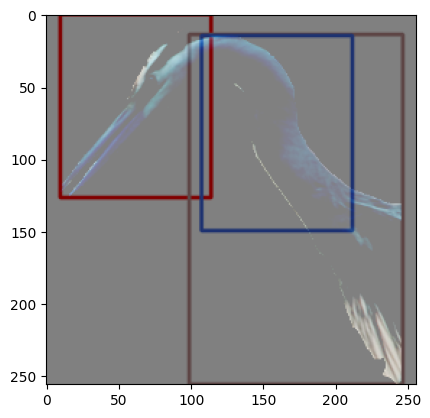

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.2492, 0.0961, 0.4805, 0.1441],
        [0.4775, 0.1021, 0.9009, 0.8769],
        [0.4805, 0.1201, 0.6066, 0.3784],
        [0.0000, 0.2673, 0.7327, 0.7688],
        [0.6967, 0.3814, 1.0000, 0.8078],
        [0.5435, 0.7658, 0.6727, 0.8438],
        [0.5435, 0.7568, 0.6246, 0.8498],
        [0.6907, 0.8559, 0.7718, 0.9039],
        [0.8018, 0.7898, 0.9189, 0.9039],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 32, 33, 34, 35, 36, 38, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lwing', 'bird rwing', 'bird lleg', 'bird 

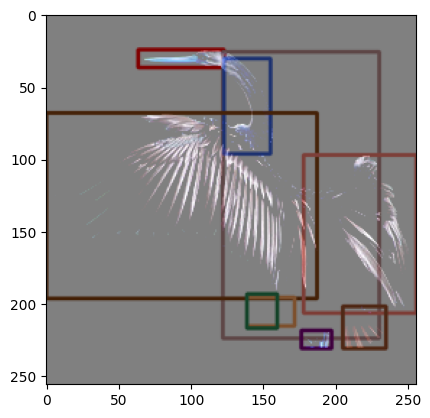

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.6875, 0.1000, 1.0000, 0.4500],
        [0.0875, 0.0500, 0.7375, 0.7250],
        [0.1500, 0.6375, 0.3250, 0.8250],
        [0.1875, 0.6500, 0.3625, 0.8125],
        [0.0000, 0.1875, 0.1000, 0.4750],
        [0.0125, 0.2000, 0.1125, 0.4750],
        [0.1375, 0.5750, 0.2250, 0.9375],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 34, 35, 36, 37, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird lleg', 'bird lfoot', 'bird rleg', 'bird rfoot', 'bird 

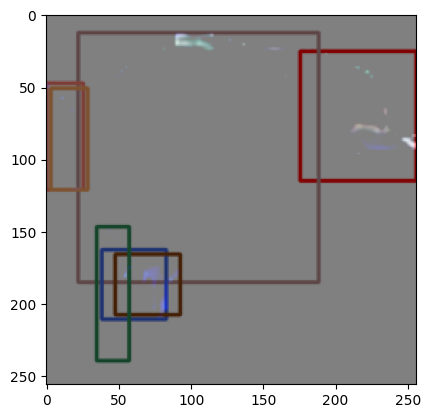

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.1937, 0.0000, 0.4189, 0.0811],
        [0.3896, 0.0698, 0.7500, 0.8423],
        [0.3671, 0.0293, 0.4910, 0.4595],
        [0.4505, 0.7027, 0.5450, 1.0000],
        [0.4527, 0.9505, 0.4932, 0.9932],
        [0.5225, 0.7140, 0.5923, 1.0000],
        [0.5225, 0.9505, 0.5968, 1.0000],
        [0.7230, 0.7703, 0.8041, 0.8851],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 34, 35, 36, 37, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lleg', 'bird lfoot', 'bird rleg', 'bird r

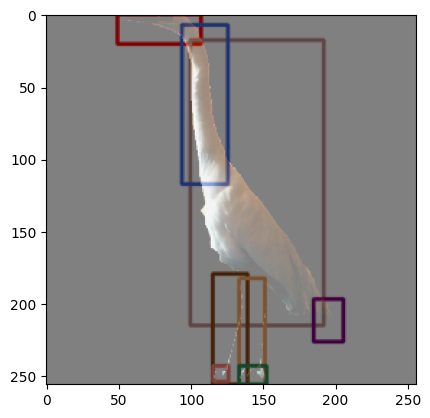

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.2268, 0.0000, 0.3673, 0.2948],
        [0.1791, 0.0227, 0.8231, 0.3832],
        [0.3424, 0.0159, 0.4014, 0.1315],
        [0.5329, 0.2472, 0.7370, 0.4989],
        [0.5306, 0.3764, 0.5918, 0.5125],
        [0.3787, 0.3764, 0.5011, 0.9955],
        [0.3719, 0.9161, 0.5011, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 31, 34, 35, 36, 37, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird neck', 'bird lleg', 'bird lfoot', 'bird rleg', 'bird r

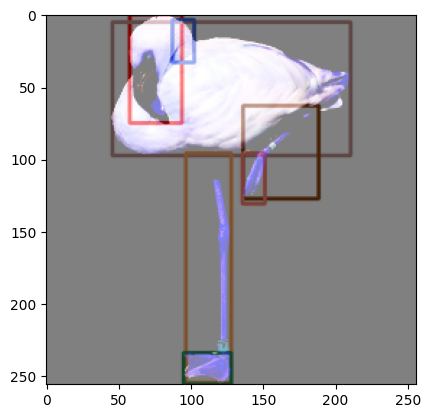

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0700, 0.2188, 0.2757, 0.4595],
        [0.1685, 0.1575, 0.5317, 0.5186],
        [0.2232, 0.0000, 0.7571, 0.5996],
        [0.1947, 0.2691, 0.3589, 0.4639],
        [0.1969, 0.2670, 0.3501, 0.4573],
        [0.2713, 0.4923, 0.3654, 0.6171],
        [0.2713, 0.5602, 0.3304, 0.6105],
        [0.4639, 0.4792, 0.9300, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 32, 34, 35, 36, 37, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird lwing', 'bird lleg', 'bird lfoot', 'bird rleg', 'bird 

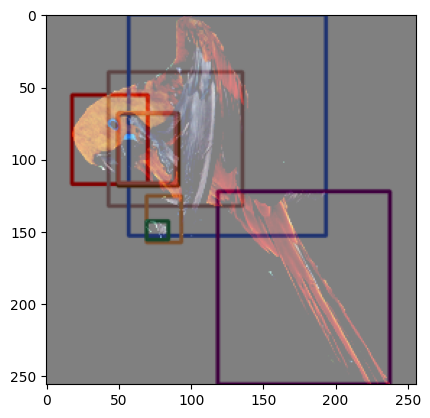

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.1882, 0.3294, 0.4000],
        [0.0784, 0.2549, 0.7961, 0.6510],
        [0.2941, 0.6275, 0.4431, 0.7686],
        [0.3216, 0.7098, 0.4118, 0.7843],
        [0.4314, 0.6510, 0.5216, 0.8118],
        [0.4353, 0.7529, 0.5216, 0.8118],
        [0.6980, 0.5098, 1.0000, 0.6314],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 34, 35, 36, 37, 38, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird lleg', 'bird lfoot', 'bird rleg', 'bird rfoot', 'bird 

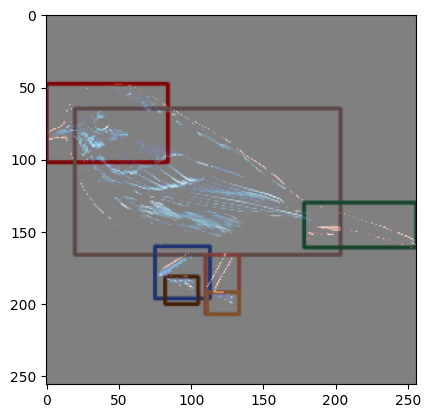

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'obj_bbox': tensor([[0.0000, 0.0000, 1.0000, 1.0000],
        [0.0788, 0.0000, 0.6659, 0.3270],
        [0.2315, 0.2697, 0.9236, 0.8854],
        [0.7064, 0.7757, 0.7971, 0.8496],
        [0.7136, 0.7780, 0.7947, 0.8592],
        [0.4248, 0.8401, 0.5298, 0.9928],
        [0.4296, 0.8377, 0.5179, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]]), 'obj_class': tensor([ 0, 29, 30, 34, 35, 36, 37, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]), 'obj_class_name': ['__image__', 'bird head leye reye beak', 'bird torso', 'bird lleg', 'bird lfoot', 'bird rleg', 'bird rfoot', '_null

KeyboardInterrupt: 

In [12]:
for i, X in enumerate(train_loader):
    x ,meta_data = X
    print(meta_data)
    #print("\n\n")
    canvas_size = 660
    gt_img = plot_bbx(meta_data['obj_bbox'][1:])
    #print(meta_data['obj_bbox'][1:])
    scaled_gt_img = Image.fromarray(gt_img).resize((256, 256))
    # Scale and normalize the second image


    # Plot the images on top of each other
    plt.imshow(scaled_gt_img)
    #plt.show()
    plt.imshow(x.permute(1,2,0),alpha=0.5 )
    plt.show()
